# TFG: Aplicación de técnicas de aprendizaje automático sobre datos con muestreo irregular
---
# Implementación de modelos
---

**Autor: Javier Caramés Muñoz**

**Universidad de La Laguna**


## 1. Introducción

Este notebook contiene la implementación práctica de los modelos expuestos en el TFG. Em concreto, se aplican y comparan varios modelos predictivos sobre datos reales procedentes de una planta MBR.*texto en cursiva*


## 2. Configuración inicial

Primero de todo debemos descargar los datos, fijar las semillas para asegurar la reproductibilidad de los modelos.

In [ ]:
import os, random, warnings
import numpy as np
import pandas as pd
import tensorflow as tf

os.environ["PYTHONHASHSEED"]  = "1"
os.environ["OMP_NUM_THREADS"] = "1"
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

data = pd.read_csv("datos_marzof.csv")


## 3. Random Forest

En esta sección se implementa un modelo multisalida basado en `RandomForestRegressor` para predecir las variables objetivo. El enfoque sigue un esquema riguroso de validación por ventanas deslizantes, que permite evaluar la capacidad de generalización temporal del modelo sobre datos de muestreo irregular.

Primero se definen distintos grupos de variables y se construyen características derivadas como:
- **Lags** de variables objetivo y exógenas.
- **Diferencias** temporales de primer orden.
- **Medias móviles** pasadas.
- **Ratios físicos** entre condiciones antes y después del retrolavado.

A continuación, se entrena un modelo Random Forest:
- En la **primera ventana**, se realiza una búsqueda de hiperparámetros con `GridSearchCV` sobre una validación con `TimeSeriesSplit`.
- En las siguientes ventanas, se reutilizan los hiperparámetros óptimos encontrados.

Finalmente, se calculan métricas globales (MAE, RMSE, R²) para cada variable objetivo y se estima la **importancia de características** mediante `permutation_importance`. También se exportan las predicciones reales vs estimadas para análisis posterior.

Dataset shape → (4143, 56); características = 54

▶ Ventana 1: train=0:2000, val=2000:2500
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros → {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 400}
TMP (ABW): R² = 0.8858
TMP (BBW): R² = 0.8807

▶ Ventana 2: train=500:2500, val=2500:3000
TMP (ABW): R² = 0.8642
TMP (BBW): R² = 0.9039

▶ Ventana 3: train=1000:3000, val=3000:3500
TMP (ABW): R² = 0.9229
TMP (BBW): R² = 0.9489

▶ Ventana 4: train=1500:3500, val=3500:4000
TMP (ABW): R² = 0.9492
TMP (BBW): R² = 0.9619

Resumen de métricas finales:
    Variable       MAE      RMSE        R2
0  TMP (ABW)  0.214057  0.323456  0.910201
1  TMP (BBW)  0.186417  0.277165  0.924295


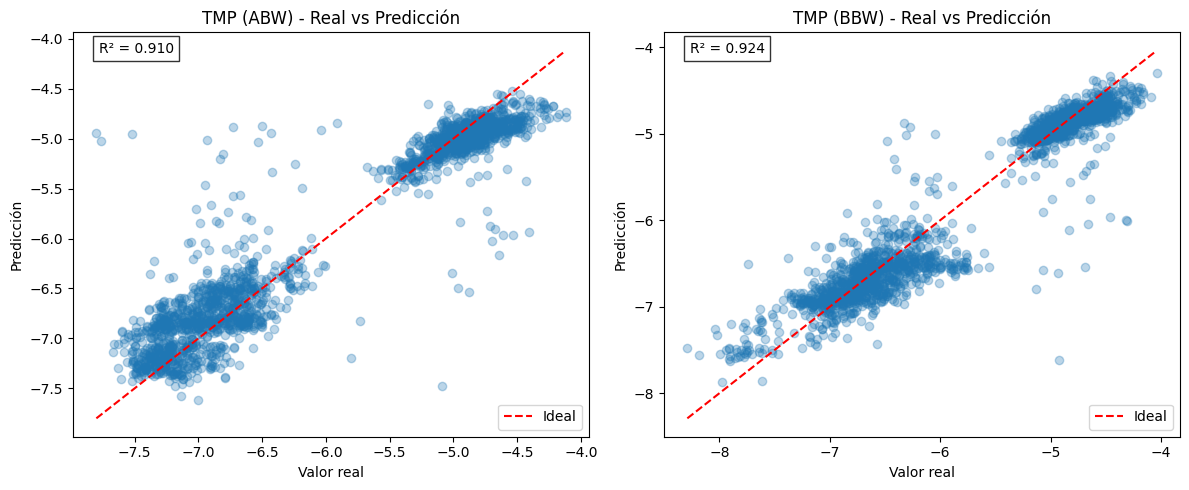

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)


# 1. Separación de variables por grupos de interés
target_cols = ["TMP (ABW)", "TMP (BBW)"]

external_vars = ["FLUX (ABW)", "J (ABW)", "FLUX (BBW)", "J (BBW)", "% Potencia bomba permeado"]

other_vars = ["Caudal Recirc. Lodo a membranas (m3/h)", "Caudal Recirc. Lodo a duchas (m3/h)",
              "Nivel Tanque aerobio (mm)", "Nivel Tanque Permeado (mm)", "Tº del permeado (ºC)", "pH del lodo"]

time_vars = ["Minutes of Operation", "Tiempo de permeado (s)", "Tiempo de BW (s)", "Delta_t", "Dia_mes", "Hora_dia"]

ratio_vars = ["FLUX_ratio_ABW_BBW", "J_ratio_ABW_BBW", "TMP_ratio_ABW_BBW" ]

target_lags = 9
external_lags = 3

# 2. Ingeniería de características

def create_advanced_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 2.1 Lags de objetivos, external y others
    for col in target_cols:
      for lag in range(1, target_lags + 1):
        df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    for col in external_vars:
      for lag in range(1, external_lags + 1):
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    for col in other_vars:
      df[f"{col}_lag_1"] = df[col].shift(1)

    # 2.2 Medias móviles y diferencias (usar shift para evitar que mire al futuro)
    for col in target_cols:
      df[f"{col}_diff_1"] = df[col].diff().shift(1)
      for window in (10, 15):
            df[f"{col}_rolling_mean_{window}"] = (df[col].shift(1).rolling(window=window, min_periods=window).mean())

    # 2.3 Ratios
    df["J_ratio_ABW_BBW"]     = (df["J (ABW)"]/ (df["J (BBW)"]+ 1e-8)).shift(1)
    df["TMP_ratio_ABW_BBW"]   = (df["TMP (ABW)"]/ (df["TMP (BBW)"]+ 1e-8)).shift(1)
    df["FLUX_ratio_ABW_BBW"]  = (df["FLUX (ABW)"]/(df["FLUX (BBW)"]+ 1e-8)).shift(1)

    return df

# 3. Construcción del conjunto de datos
data = create_advanced_features(data)
lag_cols = [f"{c}_lag_{i}" for c in target_cols for i in range(1, target_lags + 1)]
ext_cols = [f"{c}_lag_{i}" for c in external_vars for i in range(1, external_lags + 1)]
other_lag_cols = [f"{c}_lag_1" for c in other_vars]
rolling_cols = [f"{c}_rolling_mean_{w}" for c in target_cols for w in (10, 15)]
diff_cols = [f"{c}_diff_1" for c in target_cols]
input_cols = (lag_cols + ext_cols + other_lag_cols + rolling_cols + diff_cols + ratio_vars + time_vars)
df_model = data[target_cols + input_cols].dropna().reset_index(drop=True)
print(f"Dataset shape → {df_model.shape}; características = {len(input_cols)}")

# 4. Creación e implementación del modelo
train_window, validation_window, step, max_grid = 2000, 500, 500, 1
results = []
y_true_global, y_pred_global = {c: [] for c in target_cols}, {c: [] for c in target_cols}
best_params_: dict | None = None

for win_idx, start in enumerate(range(0, len(df_model) - train_window - validation_window + 1, step), 1):
    end_train = start + train_window
    end_val = end_train + validation_window
    X_train = df_model.loc[start:end_train - 1, input_cols].values
    y_train = df_model.loc[start:end_train - 1, target_cols].values
    X_val = df_model.loc[end_train:end_val - 1, input_cols].values
    y_val = df_model.loc[end_train:end_val - 1, target_cols].values
    print(f"\n▶ Ventana {win_idx}: train={start}:{end_train}, val={end_train}:{end_val}")

   # Ajuste de los hiperparametros en la primera ventana por Grid_Search
    if win_idx <= max_grid:
        param_grid = {"n_estimators": [100, 200, 400], "max_depth": [10, 20, None], "min_samples_split": [2, 5], "min_samples_leaf": [1, 3], "max_features": ["sqrt", "log2", None]}
        base_model = RandomForestRegressor(n_jobs=-1, random_state=42, oob_score=True)
        tscv = TimeSeriesSplit(n_splits=5, gap=50)
        grid = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring="neg_mean_absolute_error", cv=tscv, n_jobs=-1, verbose=1,)
        grid.fit(X_train, y_train)
        best_params_ = grid.best_params_
        model = grid.best_estimator_
        print(f"Mejores parámetros → {best_params_}")

    # Modelo con hiperparametros definidos
    else:
        assert best_params_ is not None, "Se esperaba tener best_params_ definidos."
        model = RandomForestRegressor(**best_params_, n_jobs=-1, random_state=1, oob_score=True).fit(X_train, y_train)

    y_pred = model.predict(X_val)
    for i, var in enumerate(target_cols):
      y_true_global[var].extend(y_val[:, i])
      y_pred_global[var].extend(y_pred[:, i])
      mae = mean_absolute_error(y_val[:, i], y_pred[:, i])
      rmse = np.sqrt(mean_squared_error(y_val[:, i], y_pred[:, i]))
      r2 = r2_score(y_val[:, i], y_pred[:, i])
      results.append({"Variable": var, "Ventana": f"{start}-{end_val}", "MAE": mae, "RMSE": rmse, "R2": r2})
      print(f"{var}: R² = {r2:.4f}")

# 5. Gráfico Real vs Predicción por variable
# Resumen de métricas finales
summary_results = []
for var in target_cols:
    yt = np.array(y_true_global[var])
    yp = np.array(y_pred_global[var])
    summary_results.append({
        "Variable": var,
        "MAE": mean_absolute_error(yt, yp),
        "RMSE": np.sqrt(mean_squared_error(yt, yp)),
        "R2": r2_score(yt, yp)
    })

# Mostrar tabla resumen
print("\nResumen de métricas finales:")
print(pd.DataFrame(summary_results))

# Gráfico de dispersión real vs predicción
plt.figure(figsize=(12, 5))
for i, var in enumerate(target_cols):
    yt = np.array(y_true_global[var])
    yp = np.array(y_pred_global[var])
    plt.subplot(1, 2, i + 1)
    plt.scatter(yt, yp, alpha=0.3)
    mn, mx = min(min(yt), min(yp)), max(max(yt), max(yp))
    plt.plot([mn, mx], [mn, mx], 'r--', label="Ideal")
    plt.xlabel("Valor real")
    plt.ylabel("Predicción")
    plt.title(f"{var} - Real vs Predicción")
    plt.text(0.05, 0.95, f"R² = {summary_results[i]['R2']:.3f}",
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))
    plt.legend()
plt.tight_layout()
plt.show()


## 4. MLP

En esta sección se implementa un modelo de red neuronal tipo MLP multisalida para predecir las mismas dos variables objetivo (TMP (ABW) y TMP (BBW)). Al igual que en Random Forest, usamos validación por ventanas deslizantes para evaluar robustez temporal en datos irregulares.

Al igual que antes, primero se definen los grupos de variables y se crean las características avanzadas:

- **Lags** de variables objetivo y exógenas.
- **Medias móviles** pasadas.
- **Ratios físicos** entre condiciones antes y después del retrolavado.
-  **Codificación cíclica de variables temporales**

Luego se escalan y preparan los datos para las ventanas. Después, se establece la arquitectura y formato de entreno

Finalmente, se realiza la predicción y evalúa su calidad.

Dataset shape → (4148, 59); características = 57
    Variable       MAE      RMSE        R2
0  TMP (ABW)  0.280995  0.446449  0.828622
1  TMP (BBW)  0.266582  0.412874  0.831962


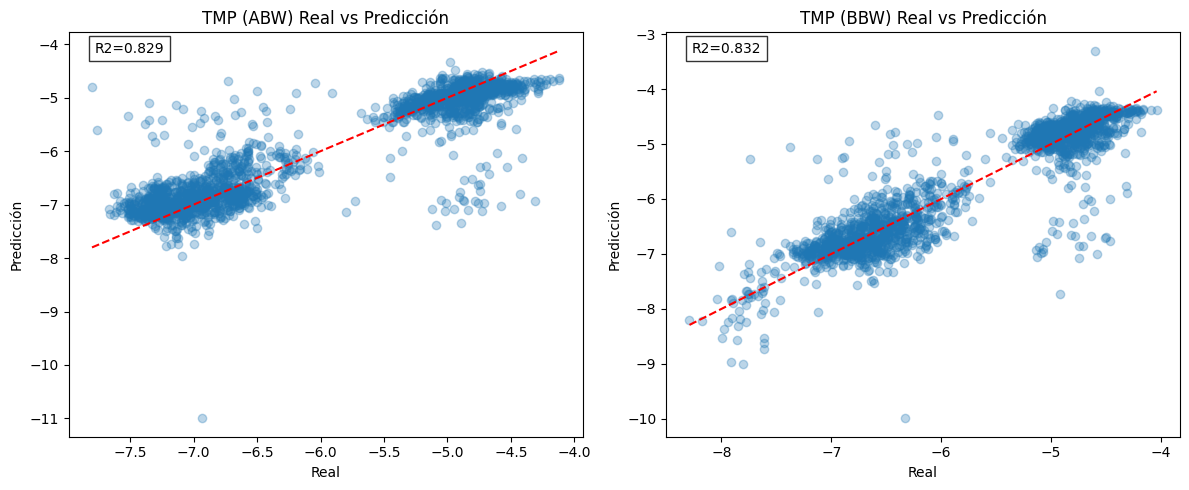

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

os.environ["PYTHONHASHSEED"]  = "1"
os.environ["OMP_NUM_THREADS"] = "1"
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

# 1. Separación de variables
target_cols = ["TMP (ABW)", "TMP (BBW)"]
external_vars = ["FLUX (ABW)", "J (ABW)", "FLUX (BBW)", "J (BBW)", "% Potencia bomba permeado"]
other_vars = ["Oxígeno disuelto (mg/l)", "Nivel Tanque aerobio (mm)", "Nivel Tanque Permeado (mm)","pH del lodo", "Tº del permeado (ºC)", "Caudal Recirc. Lodo a membranas (m3/h)","Volumen filtrado por ciclo (m3)"]
time_vars = ["Minutes of Operation", "Tiempo de permeado (s)", "Tiempo de BW (s)", "Delta_t"]
time_cyc = ["Dia_mes", "Hora_dia"]
ratio_vars = ["TMP_ratio_ABW_BBW" ]
target_lags, external_lags = 9, 3

# 2. Ingeniería de características y construcción del conjunto de datos
def create_advanced_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 2.1 Lags sobre variables
    for col in target_cols:
        for lag in range(1, target_lags + 1):
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    for col in external_vars:
        for lag in range(1, external_lags + 1):
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    for col in other_vars:
        df[f"{col}_lag_1"] = df[col].shift(1)

    # 2.2 Medias móviles
    for col in target_cols:
        for w in (5, 8, 10):
            df[f"{col}_rolling_mean_{w}"] = df[col].shift(1).rolling(window=w, min_periods=w).mean()

    # 2.3 Ratios
    df["TMP_ratio_ABW_BBW"]   = (df["TMP (ABW)"]/ (df["TMP (BBW)"]+ 1e-8)).shift(1)

    # 2.4 Codificacion ciclica
    df["hora_sin"] = np.sin(2 * np.pi * df["Hora_dia"]   / 24)
    df["hora_cos"] = np.cos(2 * np.pi * df["Hora_dia"]   / 24)
    df["dia_sem_sin"] = np.sin(2 * np.pi * (df["Dia_semana"] - 1) / 7)
    df["dia_sem_cos"] = np.cos(2 * np.pi * (df["Dia_semana"] - 1) / 7)
    df["dia_mes_sin"] = np.sin(2 * np.pi * (df["Dia_mes"]     - 1) / 31)
    df["dia_mes_cos"] = np.cos(2 * np.pi * (df["Dia_mes"]     - 1) / 31)
    return df

data = create_advanced_features(data)
lag_cols = [f"{c}_lag_{i}" for c in target_cols   for i in range(1, target_lags+1)]
ext_cols = [f"{c}_lag_{i}" for c in external_vars  for i in range(1, external_lags+1)]
other_lag_cols = [f"{c}_lag_1" for c in other_vars]
rolling_cols = [f"{c}_rolling_mean_{w}"  for c in target_cols   for w in (5,8,10)]
time_cyc = ["hora_sin","hora_cos","dia_sem_sin","dia_sem_cos","dia_mes_sin","dia_mes_cos"]
input_cols = (lag_cols + ext_cols + other_lag_cols + rolling_cols + ratio_vars + time_vars + time_cyc)
df_model = data[target_cols + input_cols].dropna().reset_index(drop=True)
print(f"Dataset shape → {df_model.shape}; características = {len(input_cols)}")

# 3. Construcción de MLP e implementación
def build_mlp(n1: int, n2: int, n3: int, dropout: float, lr: float) -> Sequential:
    model = Sequential([Input(shape=(len(input_cols),)),
        Dense(n1, activation='relu'), Dropout(dropout),
        Dense(n2, activation='relu'), Dropout(dropout),
        Dense(n3, activation='relu'), Dropout(dropout),
        Dense(len(target_cols))])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

train_window, validation_window, step = 2000, 500, 500
params = {"n1": 256, "n2": 128, "n3": 64, "dropout": 0.3, "lr": 1e-3, "batch_size": 16, "epochs": 200}
all_y_true = {v: [] for v in target_cols}
all_y_pred = {v: [] for v in target_cols}

for start in range(0, len(df_model) - train_window - validation_window + 1, step):
    end_tr = start + train_window
    end_vl = end_tr + validation_window
    X_tr = df_model[input_cols].iloc[start:end_tr].values
    y_tr = df_model[target_cols].iloc[start:end_tr].values
    X_vl = df_model[input_cols].iloc[end_tr:end_vl].values
    y_vl = df_model[target_cols].iloc[end_tr:end_vl].values
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_vl_s = scaler.transform( X_vl)
    model = build_mlp(**{k: params[k] for k in ["n1","n2","n3","dropout","lr"]})
    es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model.fit(X_tr_s, y_tr, validation_data=(X_vl_s, y_vl), epochs=params["epochs"], batch_size=params["batch_size"], callbacks=[es], verbose=0)
    y_pred = model.predict(X_vl_s, verbose=0)
    for i, v in enumerate(target_cols):
        all_y_true[v].extend(y_vl[:, i])
        all_y_pred[v].extend(y_pred[:, i])

# 4. Métricas y gráficos
results = []
for v in target_cols:
    yt = np.array(all_y_true[v])
    yp = np.array(all_y_pred[v])
    results.append({"Variable": v, "MAE":  mean_absolute_error(yt, yp), "RMSE": np.sqrt(mean_squared_error(yt, yp)), "R2":   r2_score(yt, yp)})
print(pd.DataFrame(results))
plt.figure(figsize=(12,5))
for i, v in enumerate(target_cols):
    plt.subplot(1, 2, i+1)
    yt, yp = all_y_true[v], all_y_pred[v]
    plt.scatter(yt, yp, alpha=0.3)
    mn, mx = min(yt), max(yt)
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.title(f"{v} Real vs Predicción")
    plt.xlabel("Real"); plt.ylabel("Predicción")
    plt.text(0.05, 0.95, f"R2={results[i]['R2']:.3f}",
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

# Guardar predicciones globales en DataFrame/CSV
df_preds = pd.DataFrame({"TMP (ABW)_true": all_y_true["TMP (ABW)"], "TMP (ABW)_pred": all_y_pred["TMP (ABW)"], "TMP (BBW)_true": all_y_true["TMP (BBW)"], "TMP (BBW)_pred": all_y_pred["TMP (BBW)"]})
df_preds.to_csv("predicciones_mlp.csv", index=False)


## 5. LSTM Time-Aware

En esta sección construimos un modelo Time-Aware LSTM (Baytas et al., 2017) para capturar tanto la dinámica de las señales como el intervalo de tiempo entre observaciones. El protocolo de validación por ventanas deslizantes es idéntico al de RF y MLP, de modo que los resultados son directamente comparables.

Al igual que antes, primero se definen las variables que se usaran en el modelo, como este modelo funciona con entradas por secuencias solo se establecen:

-  **Variables**: objetivos, exógenas y temporales
-  **Medías móviles y ratios**
-  **Longitud de secuencia**

A continuación se establecen las entradas, se normalizan los datos y se procede con la construcción del modelo. Se mantiene el protocolo de validación donde cada iteración mantiene una escala separada por entradas, objetivos y Δt,

Para cada ventana y cada variable TMP, se calcula y alamcena: MAE, RMSE y R². Y al terminar, se obtienen las métricas globales.

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
    Variable       MAE      RMSE        R2
0  TMP (ABW)  0.227964  0.384088  0.873708
1  TMP (BBW)  0.209018  0.352120  0.878087


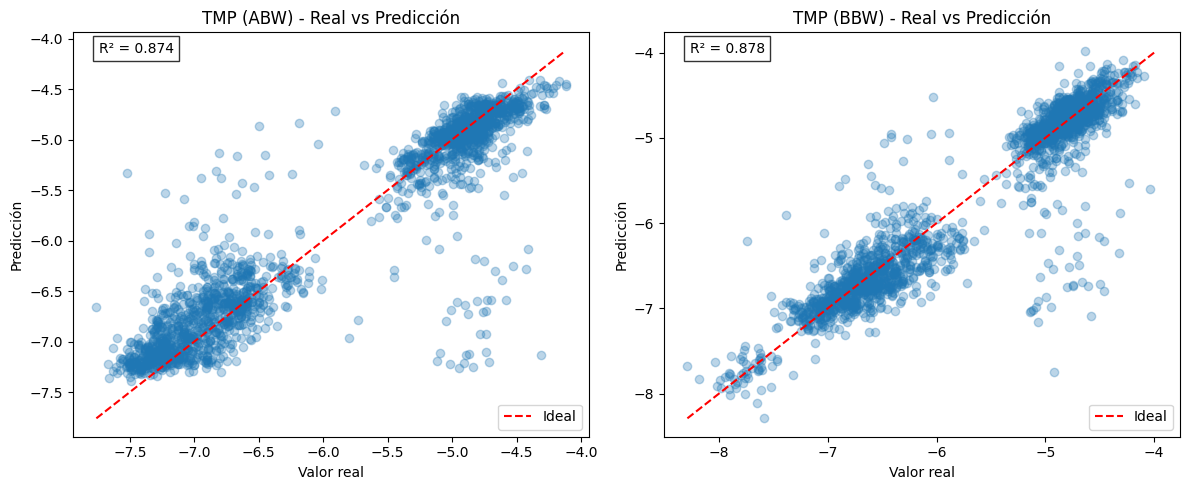

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt


# 1. Separación y creación de variables
target_cols = ["TMP (ABW)", "TMP (BBW)"]
input_cols = ['J (ABW)', 'J (BBW)', 'FLUX (ABW)', 'FLUX (BBW)', '% Potencia bomba permeado','Caudal Recirc. Lodo a membranas (m3/h)',
              'Volumen filtrado por ciclo (m3)', 'Oxígeno disuelto (mg/l)', 'Minutes of Operation', 'Tiempo de permeado (s)', 'Tiempo de BW (s)',  'Delta_t']
df = data.copy()
for c in target_cols:
  for w in (7, 12):
    df[f'{c}_rolling_mean_{w}'] = df[c].rolling(window=w).mean()
    input_cols += [f'{c}_rolling_mean_{w}']

df['TMP_ratio_ABW_BBW'] = (df['TMP (ABW)'] / (df['TMP (BBW)'] + 1e-8))
input_cols += ['TMP_ratio_ABW_BBW']
df_model = df[target_cols + input_cols].dropna()

# 2. Creación de secuencias
train_window, validation_window, step, seq_len = 2000, 500, 500, 15
def create_sequences(X, delta_t, Y, seq_len):
  X_seq, DT_seq, Y_seq = [], [], []
  X_extended = np.concatenate([X, Y], axis=1)

  for i in range(seq_len, len(X)):
    X_seq.append(X_extended[i - seq_len:i])
    DT_seq.append(delta_t[i - seq_len:i])
    Y_seq.append(Y[i])

  return np.array(X_seq), np.array(DT_seq), np.array(Y_seq)

# 3. Escalado de datos, creación de LSTM e implementación
results = []
all_y_true = {var: [] for var in target_cols}
all_y_pred = {var: [] for var in target_cols}

for start in range(0, len(df) - train_window - validation_window + 1, step):
    end_train = start + train_window
    end_val = end_train + validation_window

    df_train = df_model.iloc[start:end_train]
    df_val = df_model.iloc[end_train:end_val]

    X_train_raw, Y_train_raw, DT_train_raw = df_train[input_cols].values, df_train[target_cols].values, df_train[['Delta_t']].values
    X_val_raw, Y_val_raw, DT_val_raw  = df_val[input_cols].values, df_val[target_cols].values, df_val[['Delta_t']].values
    scaler_x, scaler_y, scaler_dt = StandardScaler().fit(X_train_raw), StandardScaler().fit(Y_train_raw), StandardScaler().fit(DT_train_raw)
    X_train_scaled, Y_train_scaled, DT_train_scaled = scaler_x.transform(X_train_raw), scaler_y.transform(Y_train_raw), scaler_dt.transform(DT_train_raw)
    X_val_scaled, Y_val_scaled, DT_val_scaled = scaler_x.transform(X_val_raw), scaler_y.transform(Y_val_raw), scaler_dt.transform(DT_val_raw)
    X_train_seq, DT_train_seq, Y_train_seq = create_sequences(X_train_scaled, DT_train_scaled, Y_train_scaled, seq_len)
    X_val_seq, DT_val_seq, Y_val_seq = create_sequences(X_val_scaled, DT_val_scaled, Y_val_scaled, seq_len)

    if len(Y_val_seq) == 0:
        continue
    input_X, input_DT = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])), Input(shape=(DT_train_seq.shape[1], 1))
    merged = Concatenate(axis=-1)([input_X, input_DT])
    x = LSTM(64, return_sequences=True)(merged)
    x = Dropout(0.3)(x)
    x = LSTM(32, return_sequences=False)(x)
    x = Dropout(0.3)(x)
    output = Dense(2, activation="linear")(x)

    model = Model(inputs=[input_X, input_DT], outputs=output)
    model.compile(optimizer='adam', loss="mse", metrics=["mae"])

    model.fit([X_train_seq, DT_train_seq], Y_train_seq, validation_data=([X_val_seq, DT_val_seq], Y_val_seq), epochs=200, batch_size=16, verbose=0,
              callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True), ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6)])

    Y_pred_scaled = model.predict([X_val_seq, DT_val_seq])
    Y_pred = scaler_y.inverse_transform(Y_pred_scaled)
    Y_true = scaler_y.inverse_transform(Y_val_seq)

    for i, var in enumerate(target_cols):
        all_y_true[var].extend(Y_true[:, i])
        all_y_pred[var].extend(Y_pred[:, i])
        mae = mean_absolute_error(Y_true[:, i], Y_pred[:, i])
        rmse = np.sqrt(mean_squared_error(Y_true[:, i], Y_pred[:, i]))
        r2 = r2_score(Y_true[:, i], Y_pred[:, i])
        results.append({"Ventana": f"{start}-{end_val}", "Variable": var, "MAE": mae, "RMSE": rmse, "R2": r2})

# 4. Métricas finales y gráfico Real vs Predicción
results_summary = []
for v in target_cols:
    yt = np.array(all_y_true[v])
    yp = np.array(all_y_pred[v])
    results_summary.append({
        "Variable": v,
        "MAE":  mean_absolute_error(yt, yp),
        "RMSE": np.sqrt(mean_squared_error(yt, yp)),
        "R2":   r2_score(yt, yp)
    })

# Mostrar tabla resumen
print(pd.DataFrame(results_summary))

# Gráfico de dispersión
plt.figure(figsize=(12, 5))
for i, v in enumerate(target_cols):
    plt.subplot(1, 2, i + 1)
    yt, yp = all_y_true[v], all_y_pred[v]
    plt.scatter(yt, yp, alpha=0.3)
    mn, mx = min(min(yt), min(yp)), max(max(yt), max(yp))
    plt.plot([mn, mx], [mn, mx], 'r--', label="Ideal")
    plt.title(f"{v} - Real vs Predicción")
    plt.xlabel("Valor real")
    plt.ylabel("Predicción")
    plt.text(0.05, 0.95, f"R² = {results_summary[i]['R2']:.3f}",
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))
    plt.legend()
plt.tight_layout()
plt.show()